In [1]:
# import needed stuff
import pandas as pd
import numpy as np
from glob import glob
import os
import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# Questions?
# How is Airbnb affected by corona?
# How is the amount of bookings over a long period of time?
# What areas in canada is most expensive?
# Is the average price on top of the rent similar over the cuntry?
# any other question?

In [3]:
### Common functions moved up here
def get_date_of_interest(start_date, end_date, df, datecolumn='date'):

    #if user choose a date outside of the dataset, set it to the min/max value
    if start_date < df[datecolumn].min():
        start_date = df[datecolumn].min()
    if end_date > df[datecolumn].max():
        end_date = df[datecolumn].max()
    return (start_date <= df[datecolumn]) & \
           (df[datecolumn]  < end_date)

def plot_count_per_time(df,start_date, end_date,ax=None,freq='W-MON',datecolumn='date',name='_nolegend_'):

    date_of_interest = get_date_of_interest(start_date, end_date, df, datecolumn=datecolumn)
    idx = pd.date_range(start_date, end_date)
    subplot = df[date_of_interest] \
            .groupby([pd.Grouper(key='date', freq=freq)])["date"] \
            .count() \
            .plot(ax=ax, alpha=0.7, label=name)
    return subplot

def filter_by_text(df,find_str,cols):
    for col_name in cols:
        for text in find_str:
            df.loc[df[col_name].str.contains(text, regex=False, na=False, case=False),'text']=True
    return df[df['text']==True]

def plot_with_quantils(df,start_date, end_date, name,freq='D', col='price',ax=None, divider=1):
    date_of_interest = get_date_of_interest(start_date, end_date, df)

    #group by date
    price = df[date_of_interest].groupby([pd.Grouper(key='date', freq=freq)])[col]

    #Calculate mean and percentiles
    date,m,q1,q2 = np.array([[date, 
                              x.mean()/divider,
                              x.quantile(0.1)/divider,
                              x.quantile(0.9)/divider] for date, x in price]).T
    ax = plt.gca() if ax is None else ax
    base_line = ax.plot_date(date, m, '-', label=name)
    # the code color=base_line[0].get_color() gives us the same color on all the lines
    # '_nolegend_' will make sure that the label is not visible.
    ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.5, label='_nolegend_' )
    ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.5, label='_nolegend_')
    return ax

In [4]:
# read data to understand the different files
# the directory should contain filders of the cities of interest
# Datasets can be found on: http://insideairbnb.com/get-the-data.html
# and https://www.cmhc-schl.gc.ca/en/data-and-research/data-tables/rental-market-report-data-tables
# extract all the files into "root_directory" under each city name, 
# the full dataset, needs to be extracted and change the name to reviewsfull.csv
## Todo, download all the data and extract files automaticaly...

root_directory = "./../airbnbdata"
folders = glob(root_directory + "/*"+ os.path.sep)
print(folders)

['./../airbnbdata/Toronto/', './../airbnbdata/Ottawa/', './../airbnbdata/Vancouver/', './../airbnbdata/Victoria/', './../airbnbdata/Montreal/', './../airbnbdata/NewBrunswick/', './../airbnbdata/Quebec/']


# step 1: Analyse the different datasets

We will take a look at a few different datasets for each city.
1. reviews, There's 2 different datasets supplied by airbnb.
In this case we will only look into the first one that is smaller, as we don't take a look at the content of the review itself for now.
2. listings, Also here's there's 2 different 
So first step is to look into if we could have any use of the bigger one.
3. Calendar.
shows future availabilities, would be better with historical as we now see the coronavirus that will change how this data looks as airbnb must be closed.

## Note, this first part is only analysing, and is part is later fixed up in step 2

In [5]:
# read in all the files:
first = folders[2]
print(first)
df_review = pd.read_csv(os.path.join(first,"reviews.csv"),parse_dates=["date"])
df_reviewfull = pd.read_csv(os.path.join(first,"reviewsfull.csv"),parse_dates=["date"])
df_listings = pd.read_csv(os.path.join(first,"listings.csv"))
df_listingsfull = pd.read_csv(os.path.join(first,"listingsfull.csv"))
df_calendar = pd.read_csv(os.path.join(first,"calendar.csv"),parse_dates=["date"],
                          converters={'price': lambda x: float(x.replace('$','').replace(',',''))})
df_neighbourhoods = pd.read_csv(os.path.join(first,"neighbourhoods.csv"))

./../airbnbdata/Vancouver/


In [6]:
# step 1, lets take a look at the size
print(df_review.shape)
print(df_reviewfull.shape)
print(df_listings.shape)
print(df_listingsfull.shape)
print(df_calendar.shape)
print(df_neighbourhoods.shape)

(214586, 2)
(214586, 6)
(6031, 16)
(6031, 106)
(2201513, 7)
(23, 2)


In [7]:
# the review one is very basic, it only contains 2 colums, date and id. 
# There's a bigger version of this, but as we wont do any nlp, we can skip this
# The use of this could be to get an approximate historical usage

In [8]:
#next, let's dive into the listings
df_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,10080,D1 - Million Dollar View 2 BR,30899,Rami,NaN,Downtown,49.28772,-123.12110,Entire home/apt,150,90,16,2017-02-26,0.16,49,320
1,13188,Garden level studio in ideal loc.,51466,Family Guns,NaN,Riley Park,49.24577,-123.10516,Entire home/apt,120,2,241,2020-03-14,1.95,1,163
2,13357,! Wow! 2bed 2bath 1bed den Harbour View Apartm...,52118,Liliana,NaN,Downtown Eastside,49.27955,-123.10546,Entire home/apt,162,30,58,2020-03-24,0.47,3,335
3,13490,Vancouver's best kept secret,52467,Iris,NaN,Kensington-Cedar Cottage,49.25550,-123.06696,Entire home/apt,145,30,84,2019-09-14,0.78,1,1
4,14267,EcoLoft Vancouver,56030,Peter & Alison,NaN,Kensington-Cedar Cottage,49.24974,-123.08108,Entire home/apt,140,3,33,2020-02-07,0.28,1,0


In [9]:
# what is the difference between the two listings? Do we need anything from the bigger set or is the smallet good enough?
print(set(df_listingsfull)-set(df_listings))

{'thumbnail_url', 'market', 'zipcode', 'weekly_price', 'notes', 'xl_picture_url', 'host_listings_count', 'experiences_offered', 'interaction', 'summary', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_value', 'host_since', 'calendar_last_scraped', 'review_scores_checkin', 'neighborhood_overview', 'space', 'minimum_maximum_nights', 'host_url', 'require_guest_phone_verification', 'minimum_nights_avg_ntm', 'host_neighbourhood', 'maximum_nights', 'security_deposit', 'square_feet', 'picture_url', 'review_scores_location', 'is_business_travel_ready', 'is_location_exact', 'requires_license', 'city', 'host_response_time', 'maximum_minimum_nights', 'cancellation_policy', 'host_thumbnail_url', 'host_identity_verified', 'host_response_rate', 'minimum_minimum_nights', 'bed_type', 'calculated_host_listings_count_shared_rooms', 'amenities', 'bathrooms', 'neighbourhood_cleansed', 'last_scraped', 'host_about', 'host_verifications', 'street', 'host_picture_url', 'monthly_price', 'prope

In [10]:
# Does the smaller include anything that's not in the big? Yes it does, but what is this?
display(set(df_listings)-set(df_listingsfull))

{'neighbourhood_group'}

In [11]:
sum(1-df_listings['neighbourhood_group'].isnull())

0

In [12]:
#however, it seem to always be null, so we can drop this
df_listings=df_listings.drop(columns=['neighbourhood_group'])

In [13]:
# now when that is done, let's take a look at what's in the bigger set but not in the small, can we find anything of interest?
pd.set_option('display.max_columns', None)
df_listingsfull.drop(columns=list(df_listings)).head()

,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,calendar_last_scraped,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,https://www.airbnb.com/rooms/10080,20200417042343,2020-04-17,"Stunning two bedroom, two bathroom apartment. ...","*Please Note: Bed setup: 2 x queen, plus 2 twi...","Stunning two bedroom, two bathroom apartment. ...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/55778229/c...,NaN,https://www.airbnb.com/users/show/30899,2009-08-10,"Vancouver, British Columbia, Canada",I will be happy to host you.,within a day,80%,67%,f,https://a0.muscache.com/im/pictures/user/55302...,https://a0.muscache.com/im/pictures/user/55302...,Coal Harbour,49,49,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Vancouver, BC, Canada",Downtown,NaN,Vancouver,BC,V6E 2P4,Vancouver,"Vancouver, Canada",CA,Canada,t,Condominium,5,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1200.0,NaN,"$4,750.00","$1,500.00",$295.00,1,$0.00,1124,90,90,1124,1124,90.0,1124.0,4 months ago,t,0,15,45,2020-04-17,0,2011-11-15,93.0,9.0,9.0,10.0,9.0,10.0,9.0,t,18-476608,"{""British Columbia"","" Canada"","" Vancouver"","" B...",f,f,strict_14_with_grace_period,f,f,49,0,0
1,https://www.airbnb.com/rooms/13188,20200417042343,2020-04-17,Garden level studio suite with garden patio - ...,Very Close (3min walk) to Nat Bailey baseball ...,Garden level studio suite with garden patio - ...,none,The uber hip Main street area is a short walk ...,Parking is free on the streets to the east and...,Check out (Website hidden by Airbnb) To see t...,NaN,We live in the house in which the suite is loc...,Limited noise after 11:00pm. Strictly NO SMOKING,NaN,NaN,https://a0.muscache.com/im/pictures/8408188/e1...,NaN,https://www.airbnb.com/users/show/51466,2009-11-04,"Vancouver, British Columbia, Canada",We are a family of four who love to travel in ...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/51466/profile...,https://a0.muscache.com/im/users/51466/profile...,Riley Park,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vancouver, BC, Canada",Riley Park,NaN,Vancouver,BC,V5Y,Vancouver,"Vancouver, Canada",CA,Canada,t,Apartment,4,1.0,0.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",NaN,$750.00,"$2,500.00",$0.00,$40.00,1,$0.00,180,2,2,1125,1125,2.0,1125.0,yesterday,t,0,13,29,2020-04-17,59,2010-02-21,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t,20-160253,"{""British Columbia"","" Canada"","" Vancouver"","" B...",t,f,moderate,f,f,1,0,0
2,https://www.airbnb.com/rooms/13357,20200417042343,20

In [14]:
# for now, we can probably do enough with the first dataset, but we can go back to this later
# the reivew set is pretty simple

In [15]:
# next we can go into the calendar.
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,10080,2020-04-17,f,150.0,$150.00,90.0,1124.0
1,226731,2020-04-17,f,176.0,$152.00,30.0,365.0
2,226731,2020-04-18,f,176.0,$152.00,30.0,365.0
3,226731,2020-04-19,f,176.0,$152.00,30.0,365.0
4,226731,2020-04-20,f,176.0,$152.00,30.0,365.0


In [16]:
# if we look into the price only:
# we can see that there's some 9999 price, this is probably not of interest.
display(df_calendar['price'].describe().apply(lambda x: format(x, 'f')))
df_calendar = df_calendar[df_calendar['price']<9999]

count    2201513.000000
mean         178.437019
std          224.625392
min           13.000000
25%           85.000000
50%          129.000000
75%          210.000000
max        13000.000000
Name: price, dtype: object

In [17]:
# daily prices and availabilities, but for what days? any historical data?
#display(df_calendar.sort_values(by=['date']).head(1))
#display(df_calendar.sort_values(by=['date']).tail(1))
sdate = df_calendar.sort_values(by=['date']).head(1)['date'].values[0]
edate = df_calendar.sort_values(by=['date']).tail(1)['date'].values[0]
print(f"the calandar contains the dates {sdate} to {edate}")

the calandar contains the dates 2020-04-17T00:00:00.000000000 to 2021-04-18T00:00:00.000000000


In [18]:
# so it seems to be a full year and only future availabilities, this may or may not be bad for us
# however, we can perhaps atleast use the review as an approximation for historical bookings, 
# not everyone leave an review, we don't know how many do it, so to make it more simple we assume 
# it's about the same everywhere and even over time.

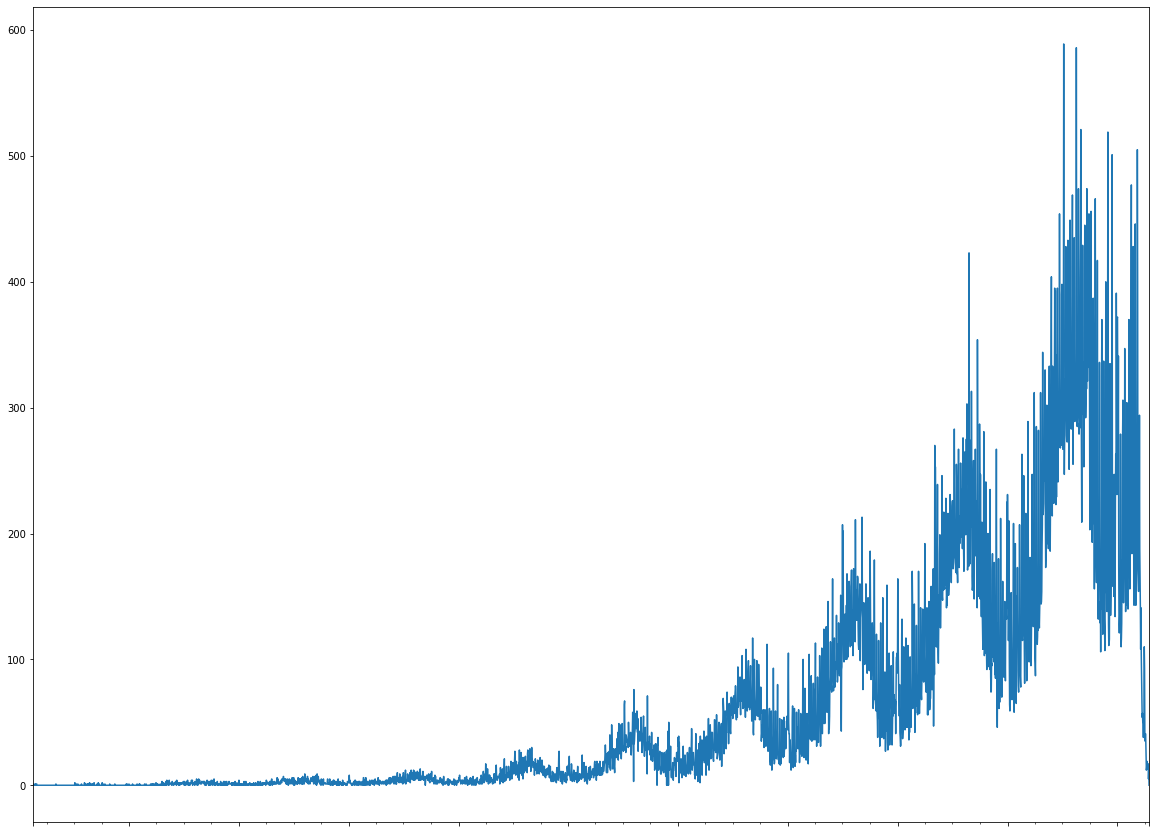

In [19]:
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2021, 12, 1)

#if user choose a date outside of the dataset, set it to the min/max value
if start_date < df_review["date"].min():
    start_date = df_review["date"].min()
    
if end_date > df_review["date"].max():
    end_date = df_review["date"].max()

date_of_interest = (start_date <= df_review["date"]) & \
                   (df_review["date"]  < end_date)
idx = pd.date_range(start_date, end_date)
subplot = df_review[date_of_interest]["date"] \
        .groupby(df_review["date"]) \
        .count() \
        .reindex(idx, fill_value=0) \
        .plot(figsize=(20,15))
ax = subplot.axes # reduce the labels to look betterkind="bar", , width=1
for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if i%90 != 0:
        label.set_visible(False)    

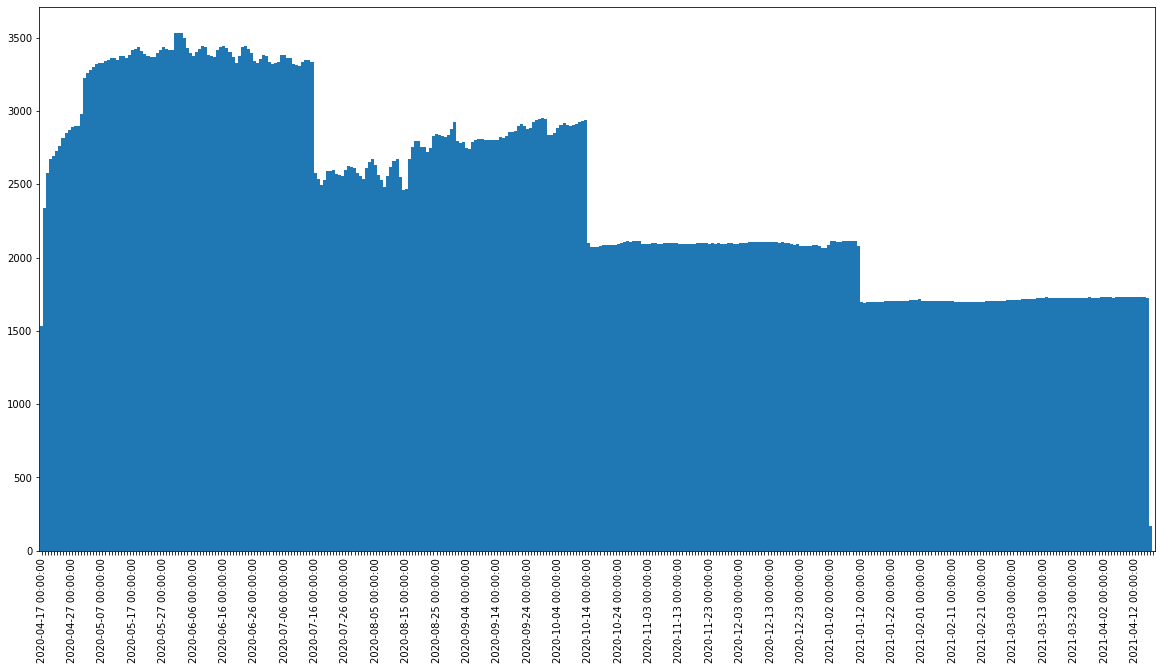

In [20]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2021, 12, 1)

#if user choose a date outside of the dataset, set it to the min/max value
if start_date < df_calendar["date"].min():
    start_date = df_calendar["date"].min()
    
if end_date > df_calendar["date"].max():
    end_date = df_calendar["date"].max()

date_of_interest = (start_date <= df_calendar["date"]) & \
                   (df_calendar["date"]  < end_date)
idx = pd.date_range(start_date, end_date)

subplot=df_calendar[date_of_interest & (df_calendar["available"] == "t")] \
        .groupby(["date"])["available"] \
        .count() \
        .reindex(idx, fill_value=0) \
        .plot(kind="bar", figsize=(20,10), width=1)
ax = subplot.axes
for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if i%10 != 0:
        label.set_visible(False)

In [21]:
#here we can see both history and future availabilities,
#We can see that in the end of the review, it goes down, this is most likely and indicator
# that covid-19 do have an effect on airbnb. however, we can also see that in the calandar
# they're still available. It would be interesting to see a better difference here. perhaps
# a comparision between more contries could be of interest, or if older calendar
# is available somewhere.
# next, we can check for corona in the listings is there any?

In [22]:
for text in ['corona','covid','virus','pandemic','pandémie']:
    df_reviewfull.loc[df_reviewfull['comments'].str.contains(text, regex=False, na=False, case=False),'text']=True


In [23]:
df_reviewfull[df_reviewfull['text']==True].shape
# in total only 69

(106, 7)

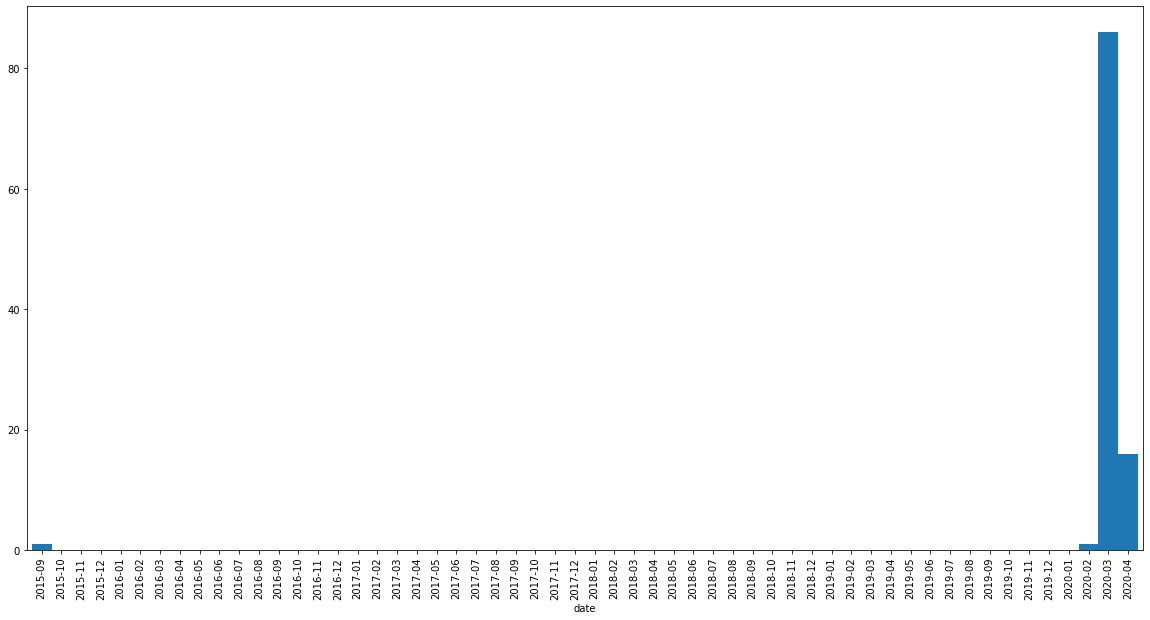

In [24]:
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2021, 12, 1)

df_virus = df_reviewfull[df_reviewfull['text']==True]
#if user choose a date outside of the dataset, set it to the min/max value
if start_date < df_virus["date"].min():
    start_date = df_virus["date"].min()
    
if end_date > df_virus["date"].max():
    end_date = df_virus["date"].max()

date_of_interest = (start_date <= df_virus["date"]) & \
                   (df_virus["date"]  < end_date)

subplot = df_virus[date_of_interest] \
        .groupby([pd.Grouper(key='date', freq='M')])["date"] \
        .count() \
        .plot(kind="bar", figsize=(20,10), width=1)

# Clean up the labels to make it look better
ax = subplot.axes
labels = []
for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    # change format
    date_label = label.get_text().split(' ')[0][:-3]
    labels.append(date_label)
    # remove every x label
    if i%1 != 0: 
        label.set_visible(False)    

ax.xaxis.set_ticklabels(labels);

In [25]:
# We can clearly see that the reviews abot virus go up thowards the end

In [26]:
# check the same with listings, however, here we don't have any historical date to use:
for text in ['covid','virus','pandemic','pandémie']: #'corona', removed due to match with corona theater
    df_listingsfull.loc[df_listingsfull['summary'].str.contains(text, regex=False, na=False, case=False),'text']=True

for text in ['covid','virus','pandemic','pandémie']: #'corona', removed due to match with corona theater
    df_listingsfull.loc[df_listingsfull['space'].str.contains(text, regex=False, na=False, case=False),'text']=True

for text in ['covid','virus','pandemic','pandémie']: #'corona', removed due to match with corona theater
    df_listingsfull.loc[df_listingsfull['description'].str.contains(text, regex=False, na=False, case=False),'text']=True

for text in ['covid','virus','pandemic','pandémie']: #'corona', removed due to match with corona theater
    df_listingsfull.loc[df_listingsfull['notes'].str.contains(text, regex=False, na=False, case=False),'text']=True

virus_text = df_listingsfull[df_listingsfull['text']==True].shape[0]/df_listingsfull.shape[0] * 100
print(f"we can see that {virus_text:.3}% of the listings have a text related to the virus")

we can see that 1.56% of the listings have a text related to the virus


In [27]:
for text in df_listingsfull[df_listingsfull['text']==True]['notes']:
    print(text)
    print("------")

nan
------
nan
------
For the FASTEST and most serene walking/cycling ROUTE TO COMMERCIAL DRIVE: May we suggest that you travel North on Lakewood Drive. You will cross a small bridge (over the train tracks), turn left at the end of it onto the Central Valley Greenway/BC Parkway/North Grandview Hwy. This will take you to the corner of E. Broadway & Victoria Drive, from here you will be able to see the Skytrain stations. Cross the street in both directions (both North and West) and continue on the BC Parkway/North Grandview Hwy in the direction of Northwest. This is a lovely shortcut, it will take you directly to Commercial Drive through a pretty and quiet residential setting. See a map of this route in the photos. Please note there are a number of local laundromats (many offer pick up/drop-off service). There is no washer/dryer on site. If you have a smart phone or laptop we would highly recommend two apps to help you find your way around town. One is called " (Hidden by Airbnb) Maps", 

In [28]:
#try read in the cities rental prices (not airbnb)
# this data can be found on https://www.cmhc-schl.gc.ca/en/data-and-research/data-tables/rental-market-report-data-tables
xls = pd.ExcelFile("./../airbnbdata/rmr-vancouver-2019-en.xlsx")
prices = pd.read_excel(xls, 1,skiprows=6,header=None)
prices.drop(columns=[2,4,6,8,10,12,14,16,18,20],inplace=True)
prices.columns = ['Zone','Bachelor18','Bachelor19','1Bedroom18','1Bedroom19','2Bedroom18','2Bedroom19','3Bedroom18','3Bedroom19','Total18','Total19']

#If we're lucky, there should be matches in these two!
display(prices.head(50))
display(df_neighbourhoods.head(50))

,Zone,Bachelor18,Bachelor19,1Bedroom18,1Bedroom19,2Bedroom18,2Bedroom19,3Bedroom18,3Bedroom19,Total18,Total19
0,Zone 1 - West End/Stanley Park,1186,1287,1469,1563,2214,2285,3201,3508,1530,1615
1,Zone 2 - English Bay,1181,1331,1579,1666,2254,2339,3586,**,1597,1701
2,Zone 3 - Downtown,1306,1360,1590,1680,2405,2545,3511,3700,1645,1733
3,West End/Downtown (Zones 1-3),1254,1340,1566,1655,2330,2441,3368,3667,1609,1702
4,Zone 4 - South Granville/Oak,1188,1202,1446,1492,1965,2016,2370,2577,1497,1541
5,Zone 5 - Kitsilano/Point Grey,1136,1276,1442,1575,2023,2141,**,2801,1527,1662
6,Zone 6 - Westside/Kerrisdale,1127,1154,1444,1486,2155,2307,3082,3160,1693,1771
7,Zone 7 - Marpole,901,1114,1048,1155,1325,1538,1477,1610,1080,1221
8,Zone 8 - Mount Pleasant/Renfrew Heights,1259,1247,1265,1300,1722,1786,**,**,1350,1383
9,Zone 9 - East Hastings,1156,1294,1172,1244,1619,1655,1466,1762,1238,1323


,neighbourhood_group,neighbourhood
0,NaN,Arbutus Ridge
1,NaN,Downtown
2,NaN,Downtown Eastside
3,NaN,Dunbar Southlands
4,NaN,Fairview
5,NaN,Grandview-Woodland
6,NaN,Hastings-Sunrise
7,NaN,Kensington-Cedar Cottage
8,NaN,Kerrisdale
9,NaN,Killarney


In [29]:
# The names don't match exactly, 
import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    text = ''.join(i for i in text if not i.isdigit())
    text = text.replace('-','').replace('/','') \
               .replace('\'','').replace('\'','') \
               .replace('zone','').replace(' ','') \
               .replace('cote','').replace('ct','')
    return str(text)


for neighbourhood in df_neighbourhoods['neighbourhood']:
    neighbourhood = strip_accents(neighbourhood.lower())
    no = True
    for neighbourhood2 in prices['Zone']:
        neighbourhood2 = strip_accents(neighbourhood2.lower())
        if neighbourhood in neighbourhood2:
            no = False
            print(f"## {neighbourhood} ## in {neighbourhood2}")

        if neighbourhood2 in neighbourhood:
            print(f"$$ {neighbourhood2} $$ in {neighbourhood}")
    if no:
        print(neighbourhood)
        
### As we now notice, some cites to have pretty good matches
# some have matches, but not possible to match direct as
# they use different shortenings.
# even worse, Vancuver only have very few matches at all
# probably the zones is just totally different then the ones
# in the airbnb dataset. To fix this, we would have to
# manually add each one bt looking at google maps and
# find the closest matches or something, this is wil 
# not be done for now.
# Instead, look into possibility of using only city as refrence

arbutusridge
## downtown ## in downtown
$$ downtown $$ in downtown
## downtown ## in westenddowntown(s)
$$ downtown $$ in downtowneastside
downtowneastside
dunbarsouthlands
fairview
grandviewwoodland
hastingssunrise
kensingtoncedarcottage
## kerrisdale ## in westsidekerrisdale
killarney
## kitsilano ## in kitsilanopointgrey
## marpole ## in marpole
$$ marpole $$ in marpole
## mountpleasant ## in mountpleasantrenfrewheights
oakridge
renfrewcollingwood
rileypark
shaughnessy
southcambie
strathcona
sunset
vioriafraserview
## westend ## in westendstanleypark
## westend ## in westenddowntown(s)
westpointgrey


In [30]:
xls = pd.ExcelFile("./../airbnbdata/rmr-canada-2019-en.xlsx")
rental_prices = pd.read_excel(xls, 1,skiprows=6,header=None)
rental_prices = rental_prices[[0,6,8]]
rental_prices.columns = ['city','condo','rms']
#cleanup the text
rental_prices['city'] = rental_prices['city'].str.replace(" CMA","").str.replace('é','e')
rental_prices.set_index('city',inplace=True)
# special fix for ottwa:
rental_prices.loc['Ottawa'] = rental_prices.loc[['Ottawa-Gatineau (Ont. part)','Ottawa-Gatineau (Que. part)']].mean()
display(rental_prices.head(50))
#here we have all our cities, now we can use this in our price calculation

,condo,rms
city,,
Halifax,1674.0,1202.0
Montreal,1274.0,855.0
Ottawa-Gatineau (Que. part),1054.0,874.0
Quebec,1074.0,862.0
Hamilton,1896.0,1219.0
Kitchener-Cambridge-Waterloo,1588.0,1231.0
London,1455.0,1107.0
Ottawa-Gatineau (Ont. part),1720.0,1410.0
Toronto,2476.0,1562.0


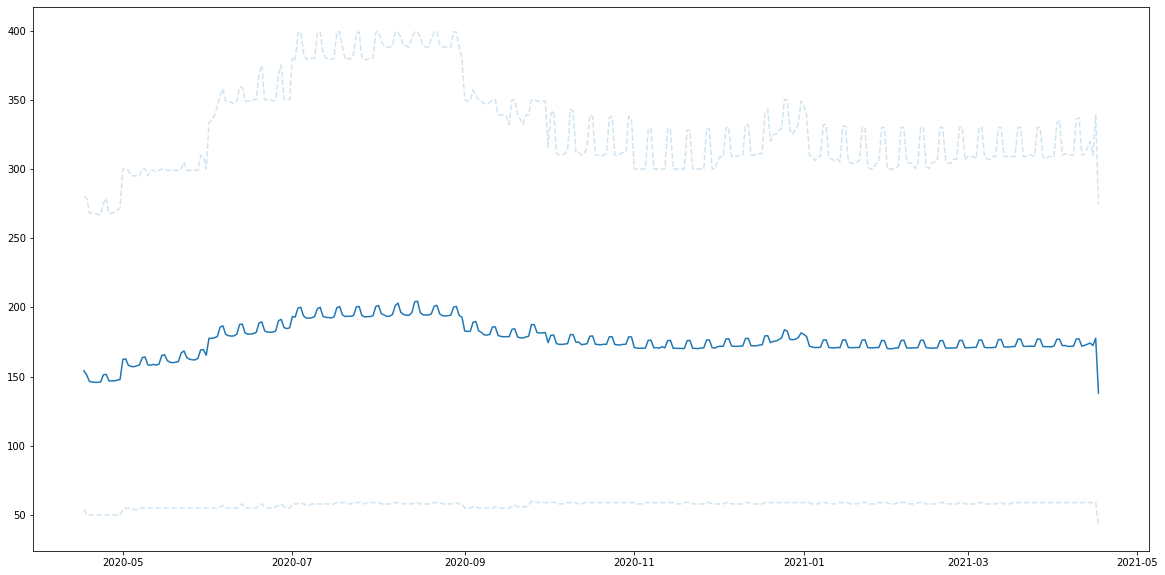

In [31]:
# now dig into the prices
date_of_interest = get_date_of_interest(datetime.datetime(2000, 5, 1), datetime.datetime(2030, 6, 1), df_calendar)

#group daes by days
price = df_calendar[date_of_interest].groupby([pd.Grouper(key='date', freq='D')])["price"]

#Calculate mean ant percentiles
date,m,q1,q2 = np.array([[date, x.mean(),x.quantile(0.1),x.quantile(0.9)] for date, x in price]).T
ax=plt.gca()
base_line = ax.plot_date(date,m,'-')
# the code color=base_line[0].get_color() gives us the same color on all the lines
ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.2)
ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.2)

In [32]:
# Looks nice, we can see that the most expensive one definetly drag the price up alot during high season
# while the cheaper stays about the same. However, this is all the types,
# does it look the same for all types of housing?
# step1 find the different housing
df_listingsfull["property_type"].value_counts()

House                 1927
Apartment             1559
Condominium           1088
Guest suite            721
Townhouse              178
Loft                   153
Guesthouse              82
Villa                   81
Serviced apartment      80
Bungalow                31
Bed and breakfast       26
Hotel                   26
Other                   21
Tiny house              11
Boutique hotel          10
Cottage                  8
Aparthotel               8
Camper/RV                6
Boat                     5
Timeshare                4
Cabin                    3
Earth house              2
Hostel                   1
Name: property_type, dtype: int64

In [33]:
condominium_id = df_listingsfull[df_listingsfull["property_type"]=='Condominium']['id']
apartment_id = df_listingsfull[df_listingsfull["property_type"]=='Apartment']['id']
df_calendar_condominium = df_calendar[df_calendar['listing_id'].isin(condominium_id)]
display(df_calendar_condominium.head())
df_calendar_apartment = df_calendar[df_calendar['listing_id'].isin(apartment_id)]
display(df_calendar_apartment.head())

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,10080,2020-04-17,f,150.0,$150.00,90.0,1124.0
500,10080,2020-04-18,f,150.0,$150.00,90.0,1124.0
719,10080,2020-04-19,f,150.0,$150.00,90.0,1124.0
720,10080,2020-04-20,f,150.0,$150.00,90.0,1124.0
721,10080,2020-04-21,f,150.0,$150.00,90.0,1124.0


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
1,226731,2020-04-17,f,176.0,$152.00,30.0,365.0
2,226731,2020-04-18,f,176.0,$152.00,30.0,365.0
3,226731,2020-04-19,f,176.0,$152.00,30.0,365.0
4,226731,2020-04-20,f,176.0,$152.00,30.0,365.0
5,226731,2020-04-21,f,176.0,$152.00,30.0,365.0


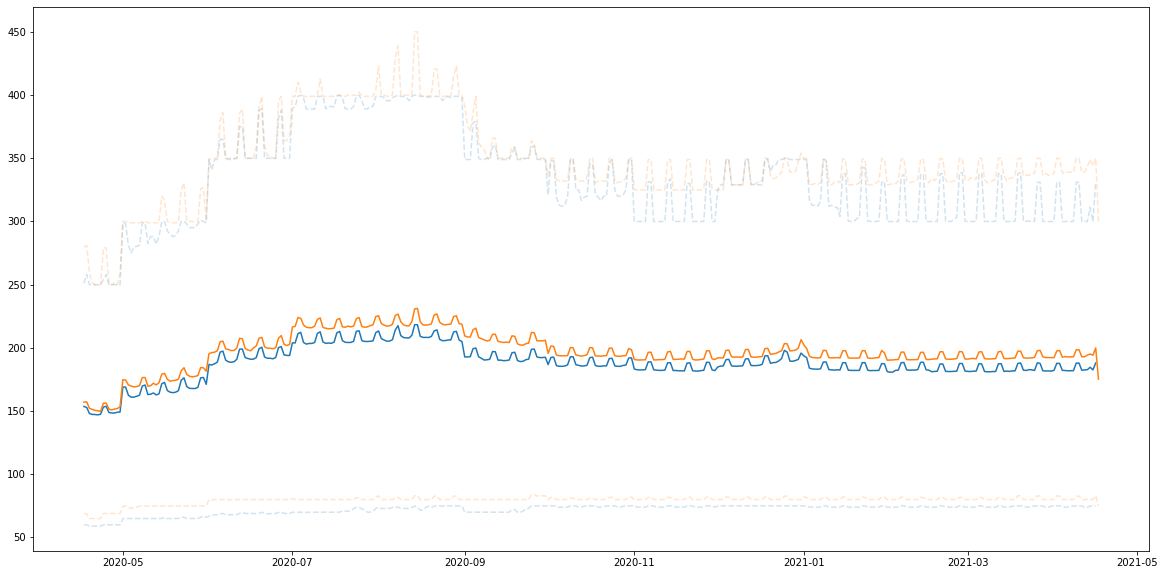

In [34]:
# now dig into the prices
date_of_interest = get_date_of_interest(datetime.datetime(2000, 5, 1), datetime.datetime(2030, 6, 1), df_calendar_apartment)

#group daes by days
price = df_calendar_apartment[date_of_interest].groupby([pd.Grouper(key='date', freq='D')])["price"]

#Calculate mean ant percentiles
date,m,q1,q2 = np.array([[date, x.mean(),x.quantile(0.1),x.quantile(0.9)] for date, x in price]).T
ax=plt.gca()
base_line = ax.plot_date(date,m,'-')
# the code color=base_line[0].get_color() gives us the same color on all the lines
ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.2)
ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.2)

# now dig into the prices
date_of_interest = get_date_of_interest(datetime.datetime(2000, 5, 1), datetime.datetime(2030, 6, 1), df_calendar_condominium)

#group daes by days
price = df_calendar_condominium[date_of_interest].groupby([pd.Grouper(key='date', freq='D')])["price"]

#Calculate mean ant percentiles
date,m,q1,q2 = np.array([[date, x.mean(),x.quantile(0.1),x.quantile(0.9)] for date, x in price]).T
ax=plt.gca()
base_line = ax.plot_date(date,m,'-')
# the code color=base_line[0].get_color() gives us the same color on all the lines
ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.2)
ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.2)

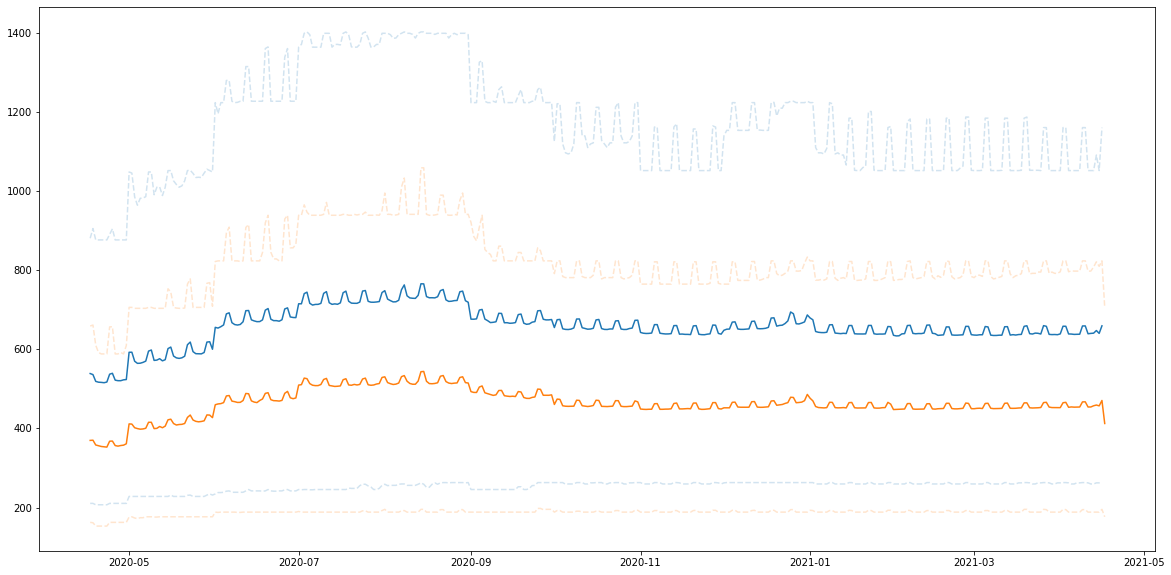

In [35]:
# not much difference between these types, just as expected appartments is cheaper than conds
# next, lets look into revenue in %
daily_price = rental_prices.loc['Montreal','rms']/30
# Samt thing again, but with relative price
date_of_interest = get_date_of_interest(datetime.datetime(2000, 5, 1), datetime.datetime(2030, 6, 1), df_calendar_apartment)

#group daes by days
price = df_calendar_apartment[date_of_interest].groupby([pd.Grouper(key='date', freq='D')])["price"]

#Calculate mean ant percentiles
date,m,q1,q2 = np.array([[date, (x.mean()/daily_price)*100
                          ,(x.quantile(0.1)/daily_price)*100
                          ,(x.quantile(0.9)/daily_price)*100] for date, x in price]).T
ax=plt.gca()
base_line = ax.plot_date(date,m,'-')
# the code color=base_line[0].get_color() gives us the same color on all the lines
ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.2)
ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.2)

# now dig into the prices
date_of_interest = get_date_of_interest(datetime.datetime(2000, 5, 1), datetime.datetime(2030, 6, 1), df_calendar_condominium)

#group daes by days
price = df_calendar_condominium[date_of_interest].groupby([pd.Grouper(key='date', freq='D')])["price"]

daily_price = rental_prices.loc['Montreal','condo']/30

#Calculate mean ant percentiles
date,m,q1,q2 = np.array([[date, (x.mean()/daily_price)*100
                          ,(x.quantile(0.1)/daily_price)*100
                          ,(x.quantile(0.9)/daily_price)*100] for date, x in price]).T
ax=plt.gca()
base_line = ax.plot_date(date,m,'-')
# the code color=base_line[0].get_color() gives us the same color on all the lines
ax.plot_date(date,q1,'--', color=base_line[0].get_color(),alpha=0.2)
ax.plot_date(date,q2,'--', color=base_line[0].get_color(),alpha=0.2)

In [36]:
# this is actually interesting, we can see that the appartments have a higher revenue in % than the condos.
# note that this is based on average rent for a 2 bedroom, as such the 1200% revenue at the 90 percentile, is more likily that 
# it's actually a very expensive flat rather than 1200% reveue.

# step 2: let's run this for all the dataset?

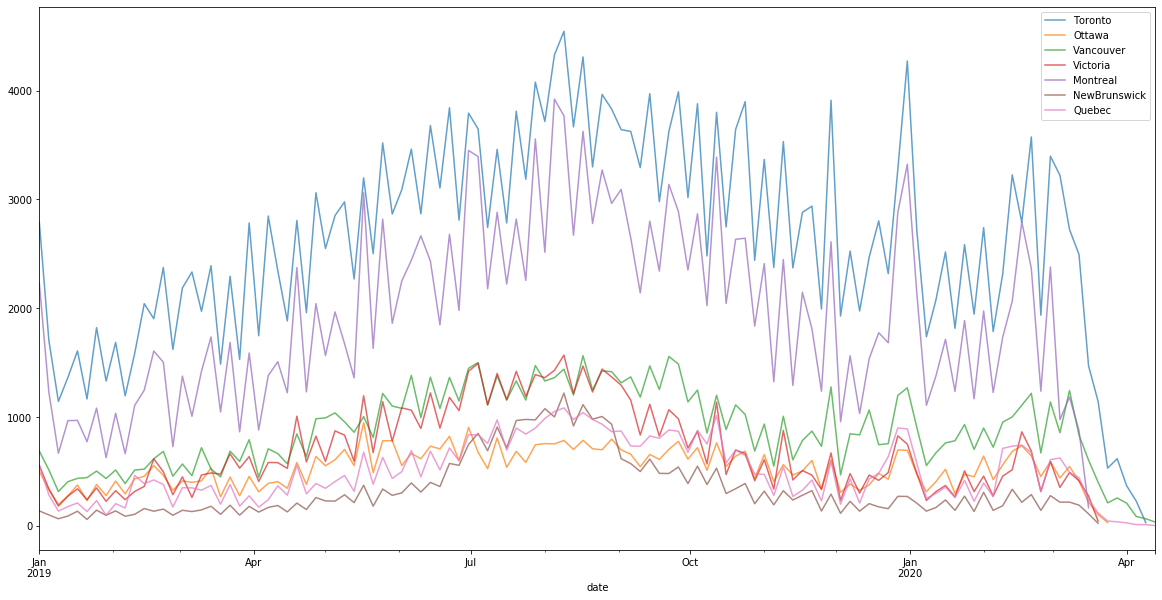

In [37]:
# Reviews over time
subplot = None
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2025, 12, 1)

for i, folder in enumerate(folders):
    df_review = pd.read_csv(os.path.join(folder,"reviews.csv"),parse_dates=["date"])
    name = folder.split('/')[-2]
    subplot = plot_count_per_time(df_review,start_date, end_date,ax=subplot,freq='4D',name=name)
subplot.legend();

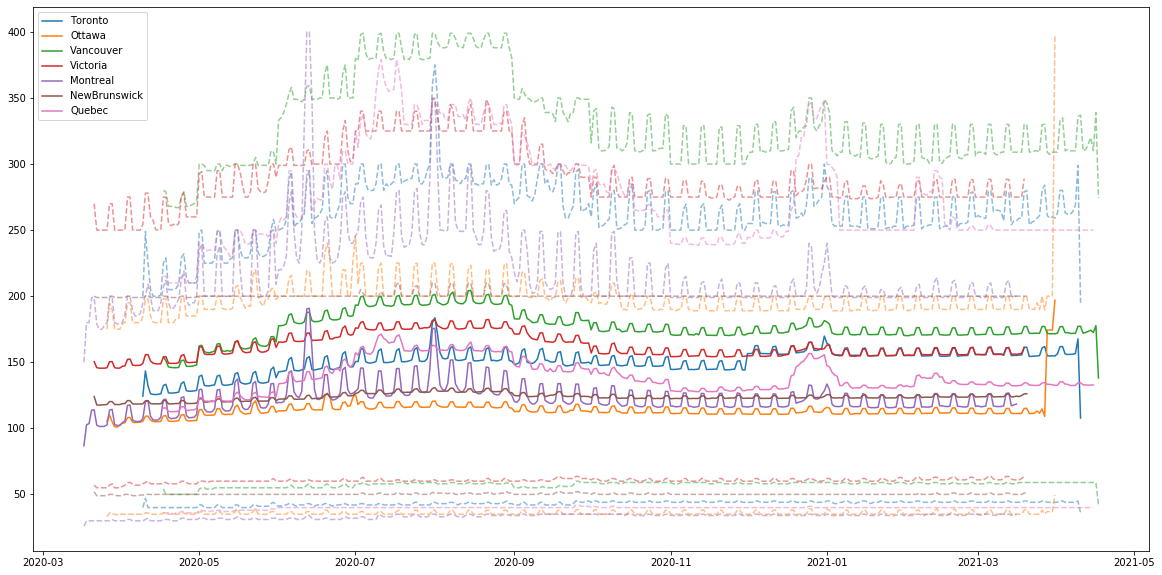

In [38]:
# price over time all cities
start_date = datetime.datetime(2000, 5, 1)
end_date = datetime.datetime(2025, 6, 1)
subplot = None

for folder in folders:
    df_calendar = pd.read_csv(os.path.join(folder,"calendar.csv"),parse_dates=["date"],
                          converters={'price': lambda x: float(x.replace('$','').replace(',',''))})
    df_calendar = df_calendar[df_calendar['price']<9999] # remove the outliers
    name = folder.split('/')[-2]
    subplot = plot_with_quantils(df_calendar,start_date, end_date,freq='D',ax=subplot, name=name)
subplot.legend()


NewBrunswick


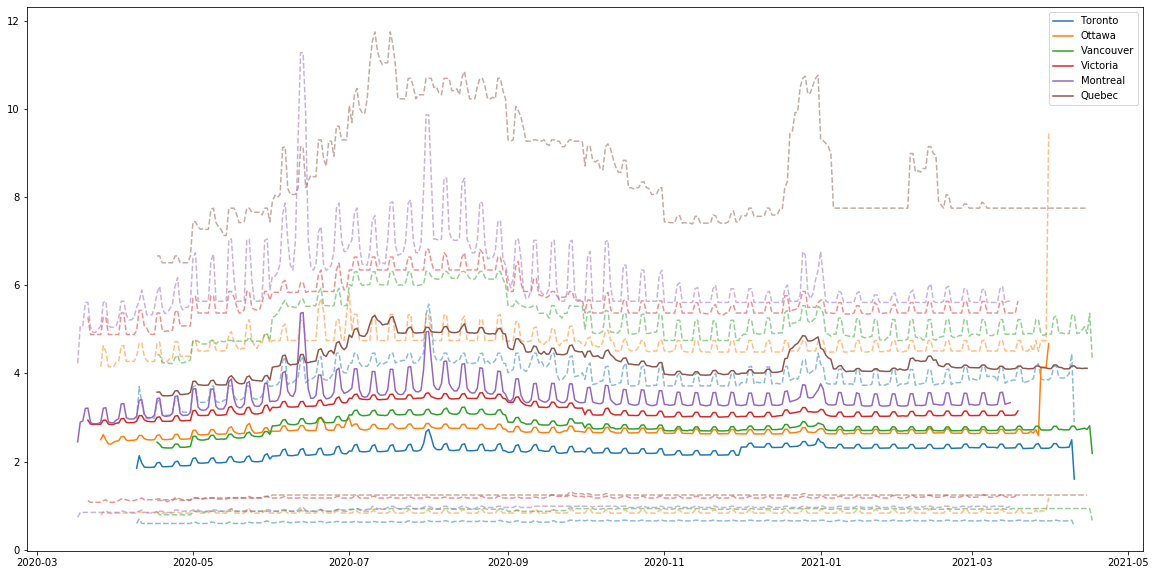

In [39]:
# relative price overtime all cities
# price over time all cities
# first get the prices per city 
xls = pd.ExcelFile("./../airbnbdata/rmr-canada-2019-en.xlsx")
rental_prices = pd.read_excel(xls, 1,skiprows=6,header=None)
rental_prices = rental_prices[[0,6,8]]
rental_prices.columns = ['city','condo','rms']
#cleanup the text
rental_prices['city'] = rental_prices['city'].str.replace(" CMA","").str.replace('é','e')
rental_prices.set_index('city',inplace=True)
# special fix for ottwa:
rental_prices.loc['Ottawa'] = rental_prices.loc[['Ottawa-Gatineau (Ont. part)','Ottawa-Gatineau (Que. part)']].mean()

start_date = datetime.datetime(2000, 5, 1)
end_date = datetime.datetime(2025, 6, 1)
subplot = None

for folder in folders:    
    name = folder.split('/')[-2]
    if name in rental_prices.index:
        rental_price = rental_prices.loc[name].mean()/30
    else:
        print(name)
        continue
    df_calendar = pd.read_csv(os.path.join(folder,"calendar.csv"),parse_dates=["date"],
                          converters={'price': lambda x: float(x.replace('$','').replace(',',''))})
    df_calendar = df_calendar[df_calendar['price']<9999] # remove the outliers

    subplot = plot_with_quantils(df_calendar,start_date, end_date,freq='D',
                                 ax=subplot, name=name, divider=rental_price)
subplot.legend()

NewBrunswick have no findings


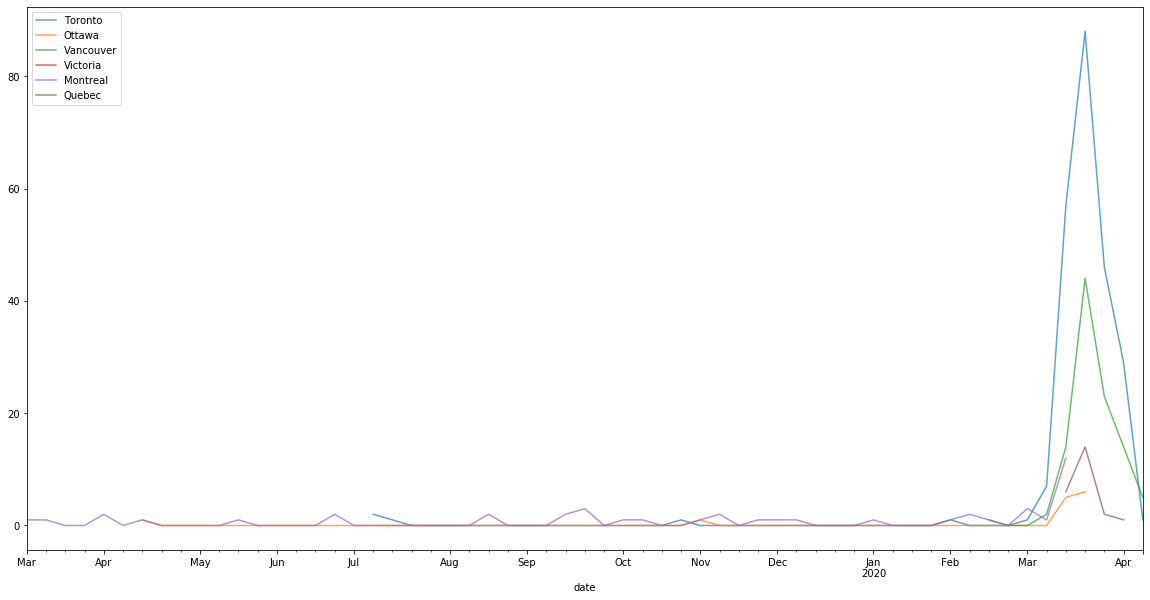

In [40]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2021, 12, 1)
subplot = None
find_str = ['corona','covid','virus','pandemic','pandémie']
cols = ['comments']


for folder in folders: 
    name = folder.split('/')[-2]
    df_reviewfull = pd.read_csv(os.path.join(folder,"reviewsfull.csv"),parse_dates=["date"])

    df_virus = filter_by_text(df_reviewfull,find_str,cols)
    if len(df_virus)<=2: 
        # todo fix ValueError: zero-size array to reduction operation fmin which has no identity
        # this do solve it, but why? the size is 2, not zero...
        print(f"{name} have no findings")
        continue
    subplot = plot_count_per_time(df_virus,start_date, end_date,ax=subplot,freq='W-MON',name=name)
subplot.legend()

In [41]:
# check the same with listings, however, here we don't have any historical date to use:
find_str = ['covid','virus','pandemic','pandémie'] # corona removed due to a theater named corona
cols = ['summary','space','description','notes']


for folder in folders: 
    name = folder.split('/')[-2]
    df_listingsfull = pd.read_csv(os.path.join(folder,"listingsfull.csv"), low_memory=False)
    df_virus = filter_by_text(df_listingsfull,find_str,cols)
    fraction_virus = df_virus.shape[0]/df_listingsfull.shape[0] * 100
    print(f"{fraction_virus:.3}% (or {df_virus.shape[0]}) of the listings in {name} have a text related to the virus")

1.64% (or 368) of the listings in Toronto have a text related to the virus
0.927% (or 30) of the listings in Ottawa have a text related to the virus
1.56% (or 94) of the listings in Vancouver have a text related to the virus
0.758% (or 30) of the listings in Victoria have a text related to the virus
1.19% (or 240) of the listings in Montreal have a text related to the virus
0.291% (or 7) of the listings in NewBrunswick have a text related to the virus
0.582% (or 16) of the listings in Quebec have a text related to the virus
